In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data
import statsmodels.api as sm
import datetime as dt

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Wine Reviews

Using a set of WineEnthusiast reviews from [Kaggle](https://www.kaggle.com/zynicide/wine-reviews/data), we attempt to answer the following questions:

- Are more expensive wines necessarily better?
- What rules-of-thumb can we use when picking wine (e.g. country, variety, year) to maximize our utility? 
  - best rated wines
  - best price/quality ratio
- What are the country/variety trends?

### Data Cleaning

We start by loading the dataset and taking a look at its first rows:

In [2]:
wine_OG = pd.read_csv(r"winemag-data-130k-v2.csv")

In [3]:
wine_OG.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [4]:
wine_OG.shape

(129971, 14)

In [5]:
wine_OG.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

The first thing we notice is that one of these columns are useless for our purposes: `unnamed`(an alternative index for the DF). We select it out of the DataFrame.

In [6]:
wine = wine_OG[['country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery']]

The second thing to notice are the missing values. We are particularly interested in points and price, so we will exclude all observations with missing values in these columns.

In [7]:
wine = wine.dropna(subset = ["points", "price"])

In [8]:
wine.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian


Next, we check that all columns of are of the right type. This is the case for this dataset, so no changes are to be made.

In [9]:
wine.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

### Data Exploration

#### Are expensive wines better?

In [10]:
wine[["points", "price"]].corr()

,points,price
points,1.000000,0.416167
price,0.416167,1.000000


There is a positive correlation (as one might expect) between points and prices. The graph below illustrates this finding: as prices increase, the ratings of wines tend to increase.

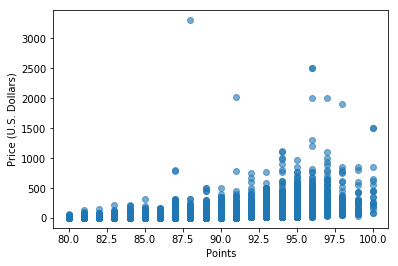

In [11]:
fig, ax = plt.subplots()
ax.scatter(wine["points"], wine["price"], alpha = 0.6)
ax.set_xlabel("Points")
ax.set_ylabel("Price (U.S. Dollars)");

The graph shows that above shows prices ranging from tens to thousands of dollars. The relationship between price/points may be more interesting to explore at a price range most of us are more likely to consider, i.e. wines below 100 dollars. Those are most, if not almost all, of the wines in this dataset.

In [12]:
cheap = (wine["price"] < 100)

In [13]:
wine["price"].quantile(0.97)

100.0

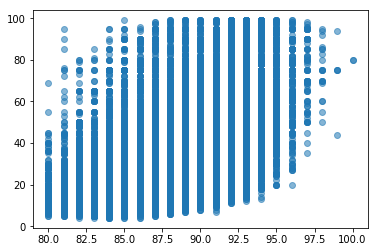

In [14]:
fig, ax = plt.subplots()
ax.scatter(wine["points"][cheap], wine["price"][cheap], alpha = 0.55); #add regression line, points on price

The positive relationship between price & points remains at the lower price point.

#### Price-Quality Ratio

With this in mind, how could we find wines with the best point-per-dollar ratio?

The code below computes this simple ratio, i.e. how many points do you get per dollar for any given wine?

In [15]:
wine["ppp"] = wine["points"] / wine["price"]

Before starting off our analysis, we should pause and consider the potential unreliability/subjectivity of reviews. Individual reviewers could be grading on wildly different criteria. 

In [16]:
wine.groupby("taster_name")[["points"]].aggregate(["mean", "count"]).head(3)

points      
                         mean count
taster_name                        
Alexander Peartree  85.854722   413
Anna Lee C. Iijima  88.405127  4369
Anne Krebiehl MW    90.612419  3398

In [17]:
wine.groupby("taster_name")[["points"]].mean().mean()

points    88.224603
dtype: float64

In [18]:
wine.groupby("taster_name")[["points"]].mean().std()

points    1.254947
dtype: float64

In this case, the reviews are fairly consistent: most reviewers have an average close to the group average (low standard deviation). 

However, there may be a second source of bias: reviews for country + variety combinations could be unreliable because they were only reviewed once or twice.

In [19]:
wine.groupby(["country", "variety"])["points"].aggregate(["mean", "count"]).sort_values(by = "mean", ascending = False).head(5)

,,mean,count
country,variety,,
Australia,Cabernet-Shiraz,96.0,1
Spain,Tinta del Pais,95.0,2
Austria,Gelber Traminer,95.0,1
Portugal,Terrantez,95.0,1
South Africa,Muscat,94.5,2


Indeed, the five country + variety combinations with the highest average points were only reviewed once or twice each. We will avoid this source of variation by focusing on better known wines. The ratings will then likely represent the 'consensus' view by the wine-tasting commmunity and may also be easier to find for the average consumer. 

The 'well known' country + variety threshold is set (arbitarily) at the top 15 percent.

In [20]:
most_reviews_threshold = wine.groupby(["country", "variety"])["points"].count().quantile(0.85)
most_reviews_threshold

39.0

We now look at the country + variety combinations with the best price-per-point ratio.

In [21]:
most_reviews = wine.groupby(["country", "variety"])["points"].count() > most_reviews_threshold
wine.groupby(["country", "variety"])["points", "price", "ppp"].mean().sort_values(by = "ppp", ascending = False)[most_reviews].head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,,points,price,ppp
country,variety,,,
Portugal,Rosé,84.602941,11.946078,7.771448
Spain,Rosé,84.851351,12.601351,7.637831
Chile,Merlot,85.257812,12.925781,7.175268
France,Cabernet Sauvignon,85.433962,18.037736,7.119661
Spain,Rosado,84.637681,13.072464,6.958892


Though these wines may seem an attractive proposition, with the number 1 promising to deliver an impressive-sounding 84 point rating for only 12 dollars, these wines are all **below average** for this dataset.

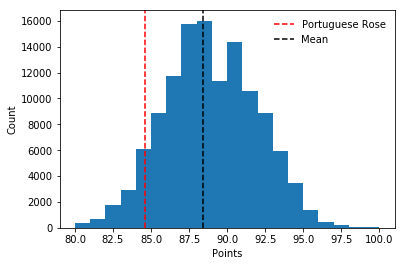

In [22]:
fig, ax = plt.subplots()
ax.hist(wine["points"], label = None, bins = 20)
plt.axvline(84.602941, color='red', linestyle='dashed', linewidth=1.5, label = "Portuguese Rose")
plt.axvline(wine["points"].mean(), color='black', linestyle='dashed', linewidth=1.5, label = "Mean")
ax.set_xlabel("Points")
ax.set_ylabel("Count")
ax.legend(frameon = False); #no frame to legend

The problem here is that it easy for cheap wines to have a high ppp ratio, but the higher the points, the more expensive the additional point-increase will be. In other words, there are *diminishing returns* to price.

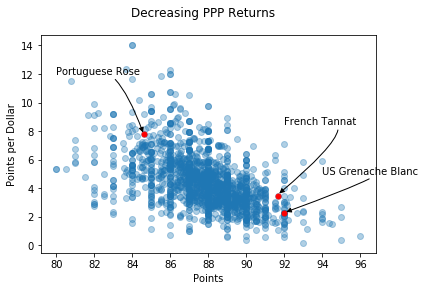

In [23]:
fig, ax = plt.subplots()
ax.scatter(wine.groupby(["country", "variety"])["points"].mean(), wine.groupby(["country", "variety"])["ppp"].mean(), 
           alpha = 0.35)
ax.plot(91.65, 3.46, marker='o', markersize= 5, color="red")
ax.plot(84.6, 7.77, marker='o', markersize= 5, color="red")
ax.plot(92, 2.3, marker='o', markersize= 5, color="red")

ax.set_xlabel("Points")
ax.set_ylabel("Points per Dollar")
fig.suptitle("Decreasing PPP Returns")

plt.annotate('French Tannat', xy=(91.65, 3.55), xytext=(92, 8.5), fontsize=10,
arrowprops=dict(arrowstyle= "-|>", connectionstyle= "angle3,angleA=5,angleB=40", facecolor='black')
)
plt.annotate('Portuguese Rose', xy=(84.6, 7.77), xytext=(80, 12), fontsize=10,
arrowprops=dict(arrowstyle= "-|>", connectionstyle= "angle3,angleA=5,angleB=110", facecolor='black')
)
plt.annotate('US Grenache Blanc', xy=(92, 2.3), xytext=(94, 5), fontsize=10,
arrowprops=dict(arrowstyle= "-|>", connectionstyle= "angle3,angleA=5,angleB=20", facecolor='black')
);

There are no free lunches in wine tastings!

The best price/point ratio will ultimately depend on the consumer's preference. Below we attempt to find the country + variety combination with the highest overall points and ppp.

In [24]:
wine.groupby(["country", "variety"])["points", "price", "ppp"].mean().sort_values(by = "points", ascending = False)[most_reviews].head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,,points,price,ppp
country,variety,,,
France,Tannat,91.647059,36.352941,3.463851
Austria,Riesling,91.495935,37.904472,3.012273
England,Sparkling Blend,91.386364,51.363636,1.950996
Italy,Sangiovese Grosso,90.807823,65.670068,1.794769
France,Riesling,90.658951,32.391975,3.427752


One of our best high-point, high-ppp wines are the French Tannat.

Other solution is to look at highest ppp for a given price range. Here, we look at wines between 40 and 60 dollars:

In [25]:
wine[(wine["price"] >= 40) & (wine["price"] <= 60)].groupby(["country", "variety"])["points", "price", "ppp"].mean().sort_values(by = "ppp", ascending = False)[most_reviews].head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


points  price     ppp
country variety                                
US      Grenache Blanc      92.0   40.0  2.3000
        Pinot Blanc         92.0   40.0  2.3000
Greece  Assyrtico           91.0   40.0  2.2750
US      Grüner Veltliner    90.0   40.0  2.2500
Chile   Sauvignon Blanc     89.5   40.0  2.2375

The US Grenache Blanc and Pinot Blanc are are best choices given this criteria.

#### Data Guide to Wine Varieties

What can we learn about wine production & reviews from this dataset?

First, most of the wines reviewed come from a handful of countries: 

In [32]:
wine["country"].value_counts().head() / wine["country"].value_counts().sum()

US          0.448783
France      0.147011
Italy       0.139882
Spain       0.054360
Portugal    0.040317
Name: country, dtype: float64

In fact, the US alone accounts for **45** percent of wines reviewed! This is likely because the reviews are mainly written by American reviewers.

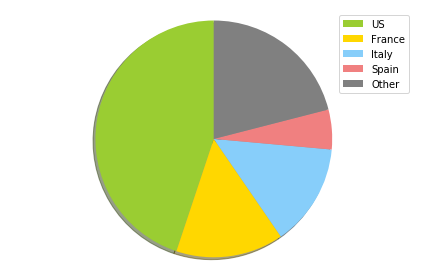

In [28]:
#https://pythonspot.com/matplotlib-pie-chart/
labels = list(wine["country"].value_counts().head(4).index)
labels.append("Other")
sizes = [i / wine["country"].value_counts().sum() for i in wine["country"].value_counts().head(4).values]
sizes.append(1 - sum(sizes))
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "grey"]
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout();

Since the fourth most reviewed country (Spain) represents barely 5% of all reviews, we'll focus on the top three: US, France and Italy.

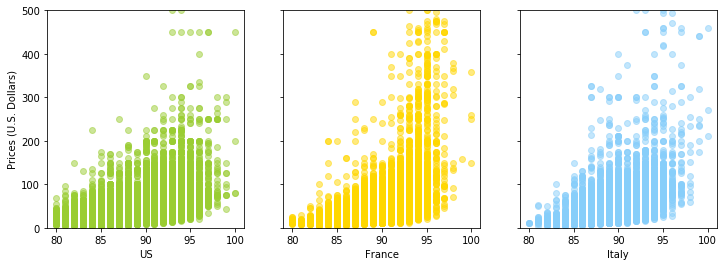

In [29]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), sharey= True)

for i in [0, 1, 2]:
    cntry_code = ["US", "France", "Italy"][i]
    color_code = ['yellowgreen', 'gold', 'lightskyblue'][i]
    ax[i].scatter(wine["points"][wine["country"] == cntry_code], wine["price"][wine["country"] == cntry_code], color = color_code, alpha = 0.5)
    ax[i].set_xlabel(cntry_code)
    ax[i].set_ylim(0, 500)
    
ax[0].set_ylabel("Prices (U.S. Dollars)");

We'll then look at the most reviewed varieties for all countries ...

In [30]:
wine["variety"].value_counts().head(5)

Pinot Noir                  12787
Chardonnay                  11080
Cabernet Sauvignon           9386
Red Blend                    8476
Bordeaux-style Red Blend     5340
Name: variety, dtype: int64

In [31]:
[i/sum(wine["variety"].value_counts()) for i in wine["variety"].value_counts().head(5)]

[0.10570039843272108,
 0.091589928414370025,
 0.077586919503364354,
 0.070064641989187756,
 0.044141716401871478]

The distribution of reviews per variety is much less skewed than reviews per countries. Still, it is worth noting that *red wines* dominate the most reviewed varieties (Pinot Noir, Cabernet Sauvignon and "Red Blends" are red wines, Chardonnay is a type of white wine).

### Findings
- American wines are overrepresented in the sample
- most wines reviewed seem to be red varieties
- there is a relationship between price and points
- we found a few country/varieties with a good points/price ratio

### Next Steps?
- Looking at regional distribution of reviews, varieties
- Comparing + graphing average points for different prices 
- Examine the vocabulary used to describe wines from different countries, regions & varieties
  - as suggested by dataset owner, find a way to classify wine based on vocabulary